In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import Image

In [2]:
from astar import *

In [3]:
import sys 
sys.path.append('..')
from animake import AniMaker
from codeprint import RawCode

# A* Search Algorithm

### Define Node Class : 
* variables : position, cost(f, g, h), parent(previous node)
* methods : 
    * \- (sub) : calculate manhattan distance
    * < (less than) : compare node cost for sorting
    * = (equal) : same node position
    * repr : print node information

In [4]:
code = RawCode('astar.py')
code.show('Node')

class Node():
    def __init__(self, position):
        self.position = tuple(position)
        self.f = self.h = 0
        self.g = np.inf
        self.parent = None
        
    def __sub__(self, other):
        # Manhattan distance
        return(sum([abs(first-last) for first, last in zip(self.position, other.position)]))
    
    def __lt__(self, other):
        # Define Less-Then operator for sorting
        return self.f < other.f
    
    def __eq__(self, other):
        return self.position == other.position
    
    def __repr__(self):
        return 'position : {0}, f : {1}\n'.format(self.position, self.f)



## Define A* Algorithm Class

In [5]:
code.show('Astar')

class Astar():
    open_list = []
    closed_list = []
    
    def __init__(self, start=None, end=None, maze=None):
        self.start = start
        self.end = end
        self.maze = maze
    
    def get_neighbor_node(self, curr_node):
        x, y = curr_node.position
        nbr_positions = [(x+1,y), (x,y-1), (x-1,y), (x,y+1)]
        return [Node(pos) for pos in nbr_positions if self.maze[pos]!=5] # 5 for wall
        
    def is_goal(self, node):
        return node == self.end
    
    def calc_cost(self, node):
        #calc cost
        node.g = node.parent.g + 1            # the cost of the cheapest path from start
        node.h = self.end - node              # heuristic : manhattan distance
        node.f = node.g + node.h    # best guess
    
    def is_update_condition(self, node, tentative_past_cost):
        #if node is in open list and cost is higher, update (delete and add).
        #if node is in open list and cost is lower, pass.
        #if node is not in open l

### Maze Example

This code uses a maze from the following URL (https://www.annytab.com/a-star-search-algorithm-in-python/).  


In [6]:
# Map configuration : maze.txt
wall = '5'
start = '2'
end = '1'

In [7]:
def load_maze():
    input_list = []
    with open("maze.txt",'r') as f:
        for line in f:
            line_num = line.replace('\n','').replace('#',wall) \
                           .replace('.','0').replace('+','0') \
                           .replace('$','0').replace('@','0') # start, end, solution reset
            input_list.append([int(num) for num in line_num])
    return np.array(input_list)

In [8]:
# Load Map : maze.txt
maze = load_maze()

start :  (39, 40)  (orange)
end :  (1, 79)  (purple)


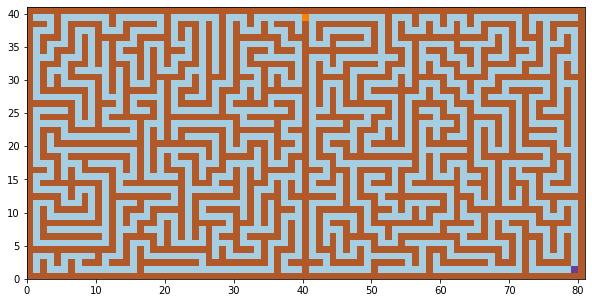

In [9]:
#find start, end point position
start_pos, end_pos = (39, 40), (1, 79)
maze[start_pos] = 3
maze[end_pos] = 4
print('start : ', start_pos, ' (orange)')
print('end : ', end_pos, ' (purple)')

%matplotlib inline
# Map Visualization
fig, ax = plt.subplots(figsize=[10,5])
plt.pcolor(maze, cmap=cm.Paired)

## Algorithm Pseudo Code

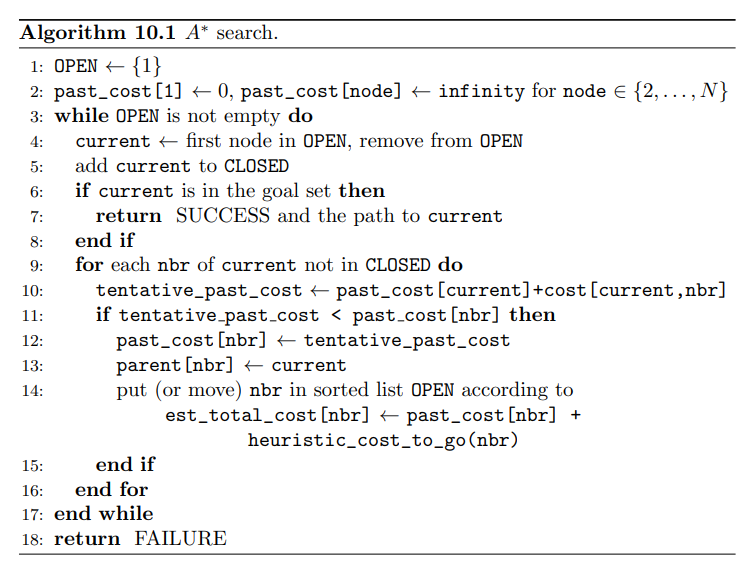

In [10]:
#pseudo code from [Modern Robotics]
Image(filename="astar_pseudocode.png", width=500)

## Initialization

In [11]:
# init
start_node = Node(start_pos)
start_node.g = 0
end_node = Node(end_pos)

astar = Astar(start_node, end_node, maze)

astar.open_list = [start_node]
astar.closed_list = []


## Search

* Loop : 
    * sort open list
    * visit lowest cost node (best first)
    * search neighbor nodes and,
        * calculate cost : g(lowest cost from start), h(heuristic cost-to-go) 
        * if node is not open list, add
        * if node is in open list, update
* 'rec' for recording path search

In [12]:
# path search order recording
rec = pd.DataFrame(columns=['x','y'])  # path search order recording

# Loop
max_iter = 10000
for i in range(max_iter):
    #iteration until open_list is empty
    if len(astar.open_list) == 0:
        print('max iteration')
        break
        
    curr_node = astar.open_list.pop(0)
    astar.closed_list.append(curr_node)

    if astar.is_goal(curr_node):
        print('Success')
        break
        
    #get neighbor position
    neighbors = astar.get_neighbor_node(curr_node)
    for nbr in neighbors:
        if nbr in astar.closed_list:
            continue
        
        tentative_past_cost = nbr.g + 1
                        
        if astar.is_update_condition(nbr, tentative_past_cost):
            nbr.g = tentative_past_cost
            nbr.h = astar.end - nbr
            nbr.f = nbr.g + nbr.h
            nbr.parent = curr_node
            astar.open_list.append(nbr)
            
            # path search order recording
            rec.loc[len(rec),:] = nbr.position
    astar.open_list.sort()
            

Success


### Reconstruct Path

* Result : 
  goal - goal.parent - goal.parent.parent - ...

In [13]:
# Find path by back tracking
for curr_ in astar.closed_list:
    maze[curr_.position] = 1
curr_ = curr_node
while curr_.parent:
    maze[curr_.position] = 4
    curr_ = curr_.parent

# Result Visualization

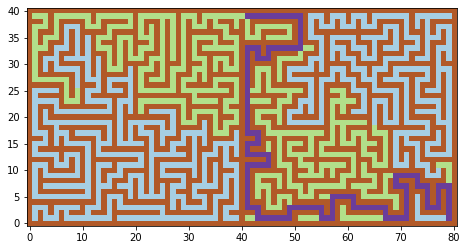

In [14]:
fig, ax = plt.subplots(figsize=[8,4])
plt.imshow(maze, cmap=cm.Paired, origin='bottom')

### Draw Animation

In [15]:
anim = AniMaker()

In [16]:
fig, ax = plt.subplots(figsize=[6,3])
maze_animation = load_maze()
im = plt.imshow(maze_animation, interpolation='none', cmap=cm.Paired, origin='bottom')
for i, row in rec.iterrows():
    x, y = row.astype(int).tolist()
    maze_animation[x,y] = 1
    if (i%10)==0 :
        im.set_array(maze_animation)
        anim.set_snapshot(cont=True)

#draw final path
curr_ = curr_node
while curr_.parent:
    maze_animation[curr_.position] = 4
    curr_ = curr_.parent
im.set_array(maze_animation)
anim.set_snapshot(num=20);
plt.close()

In [17]:
anim.make_gif('out.gif')

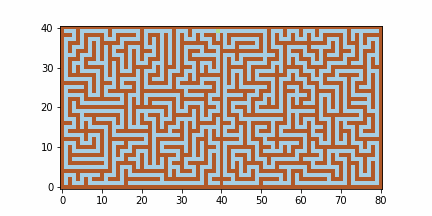

In [18]:
Image(filename="out.gif")